In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import adam

from keras.callbacks import EarlyStopping

from matplotlib.pyplot import imshow
%matplotlib inline

Using TensorFlow backend.


# create fake sample

In [2]:
mask = np.array([ [0.]*int(n/4000*141) + [0.5]*4  + [0.]*(146-int(n/4000*141)) for n in range(4000)] + [ [0]*150 ] * 4000)

In [3]:
X = np.random.rand(8000, 150)*1.04 + mask
X = np.floor(X)
Y = np.array([1]*4000 + [0]*4000).reshape( [-1,1] ).astype(float)

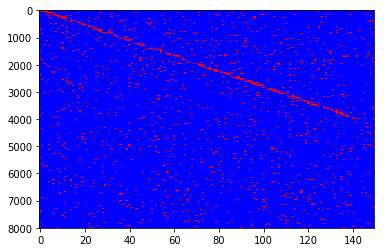

In [4]:
imshow(X, aspect='auto', cmap='bwr')

# Get significant SNP from Deep Neural Network
### Training model (Simple deep neural net with dropouts)

In [5]:
def train_model(X, Y):
    n_sample, n_feature = X.shape
    
    model = Sequential()

    model.add(Dense(99, activation='relu', input_shape=(n_feature,)))
    model.add(Dropout(rate=0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.26))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.26))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(rate=0.26))
    model.add(Dense(1,  activation='hard_sigmoid'))

    optimizer = adam(lr=0.001)
    model.compile(
        loss='mean_squared_error',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
    history = model.fit(
        X, Y, batch_size=256, epochs=100, 
        #callbacks=[early_stopping],
        verbose=0,
        validation_split=0.3)
    
    return model, history

In [6]:
model, history = train_model(X,Y)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


### Prepare extended dataset by converting(0<->1) one snp in X

In [7]:
def invert_one_pos(np_01):
    n_sample, n_feature = np_01.shape
    
    ids = np.array([np.identity(n_feature)]*n_sample)
    
    new_np_01 = ids - np_01.reshape( n_sample, 1, n_feature )
    return (abs(new_np_01))

In [8]:
def get_LoS(model, X_np):
    n_sample, n_feature = X_np.shape
    
    y_pred = model.predict(X_np)
    X_LoD = invert_one_pos(X_np).reshape( [-1, n_feature])
    y_LoD = model.predict(X_LoD)
    
    return (y_pred - y_LoD.reshape( [-1, n_feature] ))
    

### get Loss_of_Significance
LoS of one snp in a sample: original prediction of a sample - new prediction of the sample with one snp converted

In [9]:
LoS_np = get_LoS(model, X)

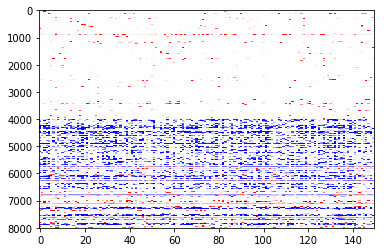

In [10]:
imshow(LoS_np, aspect='auto', cmap='bwr')

### Hierarchical clustering

In [11]:
from seaborn import clustermap

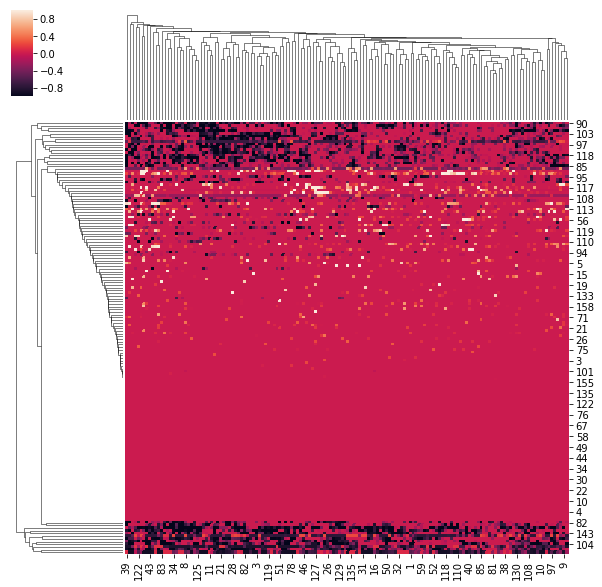

In [12]:
clustermap(LoS_np[ range(0, 8000, 50)])

# Get occurence of triple snp combinations

In [13]:
import itertools

### count all occurence with itertools store the ids of sample to the big_dict
big_dict[ combination of snp ] = list of samples who contain that combination

In [14]:
big_dict = dict()

for r in range(len(X)):
    row1 = X[r]  # boolean representation, eg [ 0, 1, 1, 0, 0, 0, 1, 0, 1 ]
    ind1 = row1.nonzero()[0]  # index representation, eg: [ 1, 2, 6, 8 ]
    
    # get all subset with 3 element, eg: [ 1, 2, 6 ] [ 1, 2, 8 ] [2, 6, 8 ]
    for tri in itertools.combinations(ind1, 3):
        if tri not in big_dict:
            big_dict[tri] = list()
        big_dict[tri].append(r)  # store it to the big dictionary


### Get big_list from big_dict for sorting
0. big_list[0] = the combination of snp
0. big_list[1] = the list of id of samples who contains that combination.
0.  big_list[2] = the length of [1] = the occurence of combination

In [15]:
big_list = [ [k, v, len(v)] for k, v in big_dict.items() ]

In [16]:
big_list[:10]

[[(0, 1, 2), [0, 12, 14, 18, 19, 52], 6],
 [(0, 1, 4), [0, 52, 4956], 3],
 [(0, 1, 33), [0, 1783], 2],
 [(0, 2, 4), [0, 52, 85], 3],
 [(0, 2, 33), [0, 3686], 2],
 [(0, 4, 33), [0], 1],
 [(1, 2, 4), [0, 34, 43, 44, 52, 76], 6],
 [(1, 2, 33), [0], 1],
 [(1, 4, 33), [0], 1],
 [(2, 4, 33), [0, 4288], 2]]

### Sort big list with third item(the occurence of combinations)

In [17]:
def sortThird(val):
    return val[2]

big_list.sort(key=sortThird, reverse=True)

In [18]:
big_list[0] # the most frequent triple pattern

[(55, 56, 57),
 [1500,
  1536,
  1537,
  1538,
  1539,
  1542,
  1549,
  1554,
  1555,
  1565,
  1567,
  1568,
  1570,
  1571,
  1575,
  1581,
  1584,
  1585,
  1586],
 19]

In [19]:
len(big_list) # number of triple pattens found

283934

### Create new sample X_new

In [36]:
X_new = np.zeros_like(X)

In [37]:
num_eligible = np.sum (np.array ([ i[2] for i in big_list ]) >= 5)

In [38]:
for tri1 in big_list[:num_eligible]:
    for s in tri1[1]:
        X_new[s, tri1[0][0] ] = 1.0
        X_new[s, tri1[0][1] ] = 1.0
        X_new[s, tri1[0][2] ] = 1.0

### compare original X and new X with frequent triple patterns

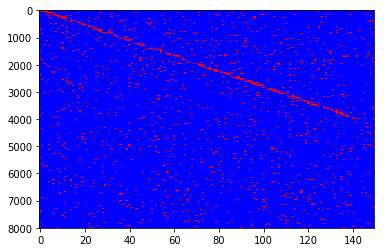

In [39]:
imshow(X, aspect='auto', cmap='bwr')

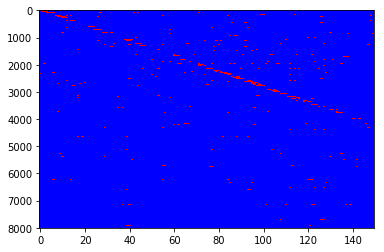

In [40]:
imshow(X_new, aspect='auto', cmap='bwr')

### hierachical clustering of original X and new X (cf. deep learning)

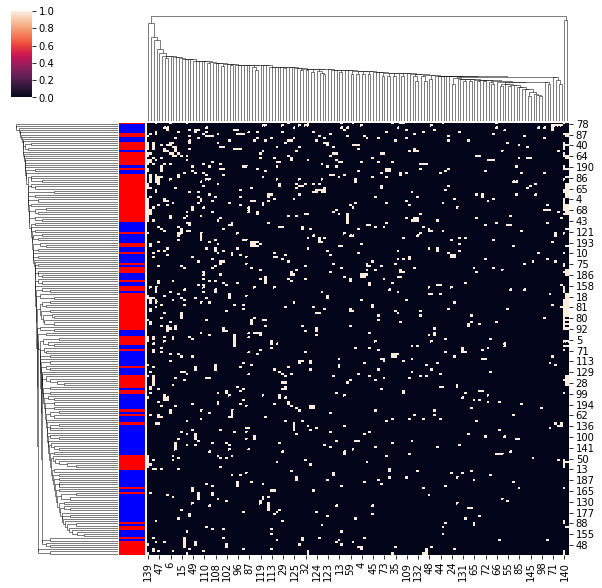

In [41]:
row_colors = ['r']*100 +  ['b']*100
clustermap(X[ range(3900,4100, 1)], row_colors=row_colors)

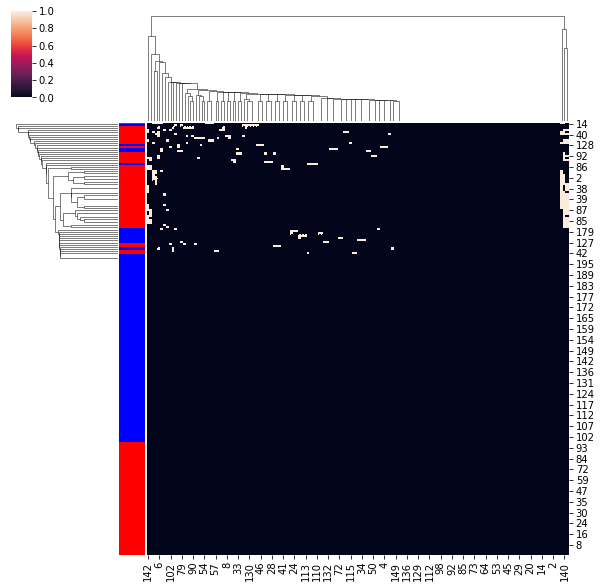

In [42]:
clustermap(X_new[ range(3900,4100, 1)], row_colors=row_colors)

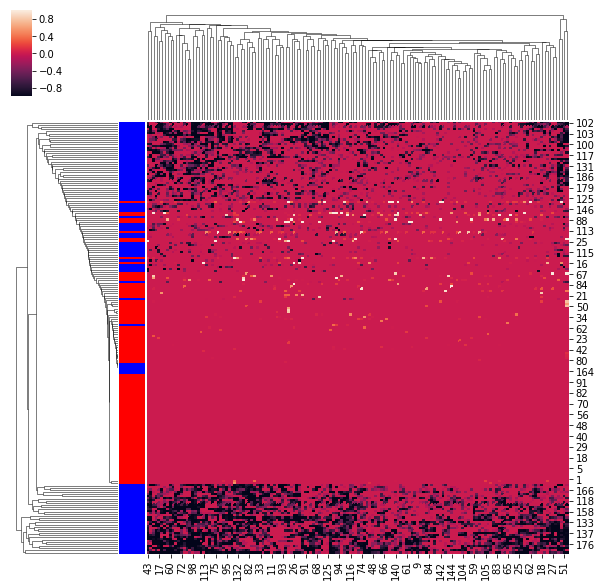

In [43]:
clustermap(LoS_np[ range(3900,4100, 1)], row_colors=row_colors)